# Credential Stuffing Detection (Failed Login Velocity)

This project detects credential stuffing attacks by analyzing high-velocity failed login
attempts across multiple user accounts from the same IP address within short time windows.


## Dataset Overview

The dataset simulates login activity captured by an authentication system. Each row
represents a single login attempt with the following fields:

- `event_id`: Unique identifier for each login attempt  
- `event_time`: Timestamp of the login event  
- `user_id`: Account being accessed  
- `ip_address`: Source IP address  
- `login_result`: Outcome of the login attempt (`success` or `fail`)


In [1]:
import pandas as pd
#same data indicating event ids, time, user id , ip address and login status
data = [
    ("e1","2024-01-01 10:01","sha965","98.239.76.120","fail"),
    ("e2","2024-01-01 10:02","sha988","98.239.76.120","fail"),
    ("e3","2024-01-01 10:03","sha999","98.239.76.120","fail"),
    ("e4","2024-01-01 10:04","sha911","98.239.76.120","fail"),
    ("e5","2024-01-01 10:05","sha777","98.239.76.120","fail"),
    ("e6","2024-01-01 10:06","ashar455","98.239.76.120","fail"),
    ("e7","2024-01-01 10:07","sha333","98.239.76.120","success"),

    ("e8","2024-01-01 11:10","usha965","98.239.76.120","success"),
    ("e9","2024-01-01 11:12","sha988","98.239.76.120","fail"),
    ("e10","2024-01-01 11:30","sha988","98.239.76.120","success"),
]

In [2]:
# converting data to dataframe
df = pd.DataFrame(
    data,
    columns=["event_id","event_time","user_id","ip_address","login_result"]
)


In [3]:
#Convert event_time to datetime
df["event_time"] = pd.to_datetime(df["event_time"])


## Time Windowing Strategy

Credential stuffing attacks occur in short bursts. To capture this behavior, login events
are grouped into fixed 10-minute time windows. This allows detection of rapid, automated
attempts that would not be visible at the individual event level.


In [4]:
#Rounds each login time down to the nearest 10 minutes.
df["time_bin_10m"] = df["event_time"].dt.floor("10min")


## Behavioral Aggregation

Login events are aggregated by IP address and 10-minute time window to calculate:

- Number of failed login attempts  
- Number of distinct user accounts targeted  
- Total number of login attempts  

These metrics form the core signals used to detect credential stuffing behavior.


In [9]:
# calculating total number of failed attempts, distinct users and total events 
window_stats = (
    df.groupby(["ip_address", "time_bin_10m"])
      .agg(
          failed_attempts=("login_result", lambda x: (x == "fail").sum()),
          distinct_users=("user_id", "nunique"),
          total_events=("event_id", "count")
      )
      .reset_index()
)

window_stats


,ip_address,time_bin_10m,failed_attempts,distinct_users,total_events
0,98.239.76.120,2024-01-01 10:00:00,6,7,7
1,98.239.76.120,2024-01-01 11:10:00,1,2,2
2,98.239.76.120,2024-01-01 11:30:00,0,1,1


In [10]:
# Threshold to create automation

FAILED_THRESHOLD = 5
USER_THRESHOLD = 3

window_stats["suspected_credential_stuffing"] = (
    (window_stats["failed_attempts"] >= FAILED_THRESHOLD) &
    (window_stats["distinct_users"] >= USER_THRESHOLD)
).astype(int)


## Investigation Evidence

For flagged attack windows, the underlying raw login events are extracted. This evidence
allows analysts to review the exact sequence of activity that triggered the alert and
supports investigation and response actions.


In [11]:
#create the alert queue
alerts = window_stats[window_stats["suspected_credential_stuffing"] == 1]
alerts


,ip_address,time_bin_10m,failed_attempts,distinct_users,total_events,suspected_credential_stuffing
0,98.239.76.120,2024-01-01 10:00:00,6,7,7,1


In [12]:
#why the alert fired.
flagged_ip = alerts.iloc[0]["ip_address"]
flagged_window = alerts.iloc[0]["time_bin_10m"]

evidence = df[
    (df["ip_address"] == flagged_ip) &
    (df["time_bin_10m"] == flagged_window)
].sort_values("event_time")

evidence


,event_id,event_time,user_id,ip_address,login_result,time_bin_10m
0,e1,2024-01-01 10:01:00,sha965,98.239.76.120,fail,2024-01-01 10:00:00
1,e2,2024-01-01 10:02:00,sha988,98.239.76.120,fail,2024-01-01 10:00:00
2,e3,2024-01-01 10:03:00,sha999,98.239.76.120,fail,2024-01-01 10:00:00
3,e4,2024-01-01 10:04:00,sha911,98.239.76.120,fail,2024-01-01 10:00:00
4,e5,2024-01-01 10:05:00,sha777,98.239.76.120,fail,2024-01-01 10:00:00
5,e6,2024-01-01 10:06:00,ashar455,98.239.76.120,fail,2024-01-01 10:00:00
6,e7,2024-01-01 10:07:00,sha333,98.239.76.120,success,2024-01-01 10:00:00


Matplotlib is building the font cache; this may take a moment.


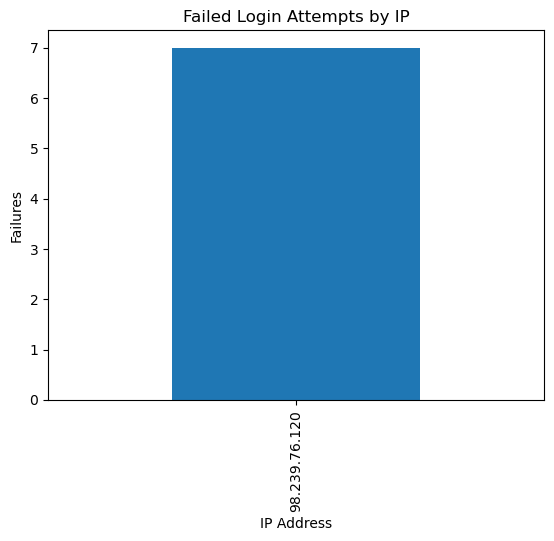

In [13]:
# adding visualization
import matplotlib.pyplot as plt

(df[df["login_result"] == "fail"]
 .groupby("ip_address")
 .size()
 .sort_values(ascending=False)
 .plot(kind="bar"))

plt.title("Failed Login Attempts by IP")
plt.xlabel("IP Address")
plt.ylabel("Failures")
plt.show()


This project detects credential stuffing by identifying high-velocity failed login
attempts across multiple user accounts from the same IP within short time windows.
Suspicious activity is flagged using explainable thresholds, and supporting event
evidence is surfaced for investigation.
